# Sentiment Analysis for Indodax App Reviews

In [3]:
!pip install google_play_scraper Sastrawi

## Project Overview

We'll build a deep learning model to classify Indodax app reviews as positive or negative. Here's the approach we'll take:

1. **Data Preprocessing**: Clean and prepare the Indonesian text data
2. **Feature Extraction**: Convert text data into numerical features
3. **Model Building**: Create and train a deep learning model
4. **Evaluation**: Assess model performance
5. **Prediction**: Apply the model to new reviews


## Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)


In [5]:
# Create DataFrame from scraped reviews
reviews_df = pd.read_csv('../data/reviews_aplikasi_indodax.csv')

# Display basic information
print(f"Total reviews collected: {len(reviews_df)}")
reviews_df.head()

Total reviews collected: 63804


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,7ddd0d32-d207-4861-9bf5-d12f0287e584,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Teruslah berinovasi agar server semakin lebih ...,5,20,5.4.9,2025-04-23 13:27:16,Dear member Indodax. Terima kasih atas partisi...,2021-08-22 10:02:43,5.4.9
1,d013a9e0-fe06-4786-b8f1-570314474973,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya makin keren! Tampilan INDODAX 3.0 ...,5,4,5.4.9,2025-04-25 18:27:18,"Dear member, terima kasih telah mengikuti even...",2025-04-25 19:03:28,5.4.9
2,a248271f-6ddc-4228-9bf5-04da5f79f5d3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasinya mohon diperbaiki, kemarin malam sa...",2,0,5.4.9,2025-04-25 10:51:02,Dear member INDODAX. Mohon maaf atas ketidakny...,2025-04-25 11:09:02,5.4.9
3,341a36c9-80b7-427d-a346-a251df43fbb6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sebagai user setia dengan username Bycaa, saya...",5,14,5.4.8,2025-04-19 16:16:01,"Dear member, terima kasih telah mengikuti even...",2025-04-19 18:16:45,5.4.8
4,0988bd46-4249-4679-aa03-63ac52bffa2f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"apk sampah, transaksinya sangat lambat sekalip...",1,5,5.4.8,2025-04-22 23:06:03,Dear member INDODAX. Mohon maaf atas ketidakny...,2025-04-22 23:28:13,5.4.8


In [6]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63804 entries, 0 to 63803
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              63804 non-null  object
 1   userName              63804 non-null  object
 2   userImage             63804 non-null  object
 3   content               63803 non-null  object
 4   score                 63804 non-null  int64 
 5   thumbsUpCount         63804 non-null  int64 
 6   reviewCreatedVersion  50611 non-null  object
 7   at                    63804 non-null  object
 8   replyContent          63804 non-null  object
 9   repliedAt             63804 non-null  object
 10  appVersion            50611 non-null  object
dtypes: int64(2), object(9)
memory usage: 5.4+ MB


### Drop duplicate values dan null values

In [7]:
reviews_df.dropna(inplace=True)

In [8]:
reviews_df.drop_duplicates(inplace=True)

In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50610 entries, 0 to 63789
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              50610 non-null  object
 1   userName              50610 non-null  object
 2   userImage             50610 non-null  object
 3   content               50610 non-null  object
 4   score                 50610 non-null  int64 
 5   thumbsUpCount         50610 non-null  int64 
 6   reviewCreatedVersion  50610 non-null  object
 7   at                    50610 non-null  object
 8   replyContent          50610 non-null  object
 9   repliedAt             50610 non-null  object
 10  appVersion            50610 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.6+ MB


## Step 2: Data Preprocessing

In [15]:
# Import text preprocessing libraries
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download required NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')

# Text cleaning functions
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]', '', text)         # Remove RT
    text = re.sub(r'http\S+', '', text)        # Remove links
    text = re.sub(r'[0-9]+', '', text)         # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)        # Remove special characters
    text = text.replace('\n', ' ')             # Replace newlines with space
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()                        # Remove extra spaces
    return text


# Convert to lowercase
casefold_text = lambda text: text.lower()

# Tokenize text
tokenize_text = lambda text: word_tokenize(text)

# Remove stopwords
def filter_stopwords(tokens):
    indo_stopwords = set(stopwords.words('indonesian'))
    eng_stopwords = set(stopwords.words('english'))
    all_stopwords = indo_stopwords.union(eng_stopwords)

    # Add custom stopwords relevant to app reviews
    custom_stopwords = {'aplikasi', 'app', 'indodax', 'nya', 'yg', 'di', 'ke', 'ga', 'gak', 'tidak', 'ya', 'ini', 'dan', 'di', 'ke', 'dari'}
    all_stopwords.update(custom_stopwords)

    return [word for word in tokens if word not in all_stopwords]


# Stemming (reducing words to their root form)
def stem_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# Convert tokens back to sentence
tokens_to_sentence = lambda tokens: ' '.join(tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "apk": "aplikasi"}


def fix_slangwords(text):
    words = text.strip().split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [17]:
# Apply preprocessing to the reviews
reviews_df['clean_text'] = reviews_df['content'].apply(clean_text)
reviews_df['casefolded_text'] = reviews_df['clean_text'].apply(casefold_text)
reviews_df['text_slangwords'] = reviews_df['casefolded_text'].apply(fix_slangwords)
reviews_df['tokens'] = reviews_df['text_slangwords'].apply(tokenize_text)
reviews_df['filtered_tokens'] = reviews_df['tokens'].apply(filter_stopwords)
reviews_df['processed_text'] = reviews_df['filtered_tokens'].apply(tokens_to_sentence)


# Display processed data
reviews_df[['content', 'processed_text', 'filtered_tokens']].head()

,content,processed_text,filtered_tokens
0,Teruslah berinovasi agar server semakin lebih ...,teruslah berinovasi server stabil realtime mar...,"[teruslah, berinovasi, server, stabil, realtim..."
1,"Sebagai user setia dengan username Bycaa, saya...",user setia username bycaa benarbenar puas upda...,"[user, setia, username, bycaa, benarbenar, pua..."
2,INDODAX cocok banget bagi pemula seperti saya ...,cocok banget pemula terjun dunia crypto aplika...,"[cocok, banget, pemula, terjun, dunia, crypto,..."
3,"apk sampah, transaksinya sangat lambat sekalip...",sampah transaksinya lambat ethereum kecepatan ...,"[sampah, transaksinya, lambat, ethereum, kecep..."
4,INDODAX adalah platform kripto lokal yang user...,platform kripto lokal userfriendly banget apli...,"[platform, kripto, lokal, userfriendly, banget..."


### Step 3: Labeling and Feature Extraction

In [18]:
import csv
import requests
from io import StringIO

def read_lexicon(url):
    lexicon = dict()
    response = requests.get(url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        # Membaca teks response sebagai file CSV menggunakan CSV dengan pemisah koma

        for row in reader:
            # Mengulangi setiap baris dalam file CSV
            lexicon[row[0]] = int(row[1])
            # Menambahkan kata-kata dan skornya dalam kamus lexicon
    else:
        print("Failed to fetch negative lexicon data")

    return lexicon

# Loads positive lexicon
lexicon_positive = read_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Loads negative lexicon
lexicon_negative = read_lexicon('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')


In [19]:
# Function to determine sentimen polarity of tweets
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks
        if (word in lexicon_positive):
            score += lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangin setipa kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score += lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, tambahkan skornya ke skor sentimen

    polarity = ''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score == 0):
        polarity = 'neutral'
        # Jika skor sentimen sama dengan 0, maka polaritas adalah netral
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    return score, polarity

In [20]:
results = reviews_df['filtered_tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
reviews_df['polarity_score'] = results[0]
reviews_df['polarity'] = results[1]

print(reviews_df['polarity'].value_counts())

polarity
positive    27787
negative    11620
neutral     10990
Name: count, dtype: int64


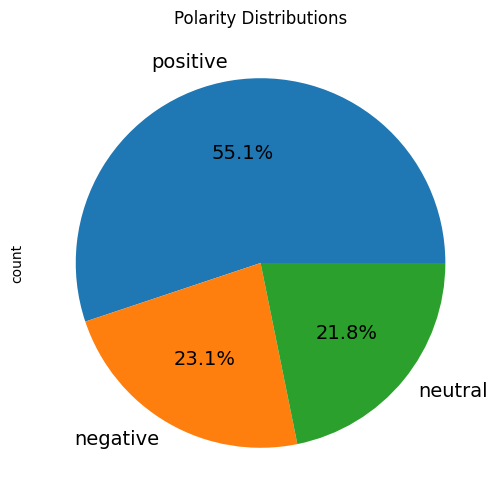

In [21]:
reviews_df['polarity'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(7, 6), labels=reviews_df['polarity'].value_counts().index, textprops={'fontsize': 14}, title='Polarity Distributions')
plt.show()

In [22]:
# Mengatur opsi tambahan pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = reviews_df[reviews_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'
positive_tweets = positive_tweets[['processed_text', 'polarity_score', 'polarity', 'filtered_tokens']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame
positive_tweets.index += 1

In [23]:
# Mengatur opsi tambahan pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
negative_tweets = reviews_df[reviews_df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'
negative_tweets = negative_tweets[['processed_text', 'polarity_score', 'polarity', 'filtered_tokens']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame
negative_tweets.index += 1

In [24]:
# Create word clouds for positive and negative reviews
from wordcloud import WordCloud

# Function to create word cloud
def create_wordcloud(text_series, title):
    text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
        max_words=100, contour_width=3, contour_color='steelblue'
    ).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


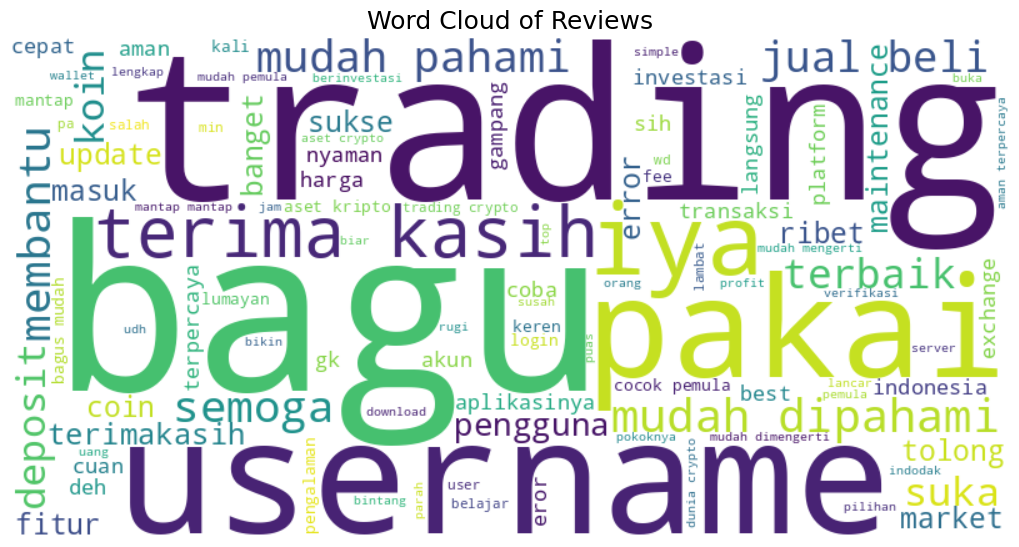

In [25]:
create_wordcloud(reviews_df['processed_text'], 'Word Cloud of Reviews')

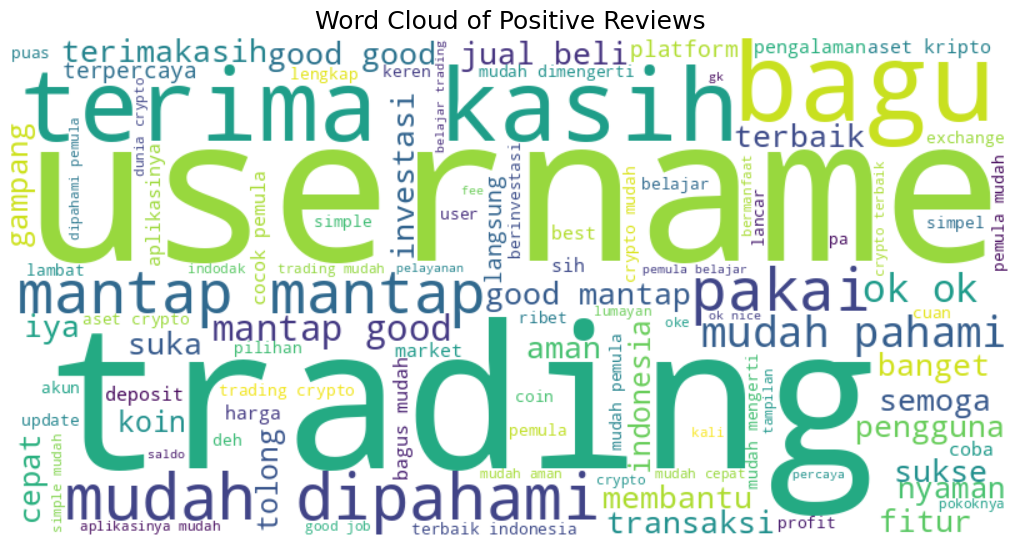

In [26]:
create_wordcloud(positive_tweets['processed_text'], 'Word Cloud of Positive Reviews')

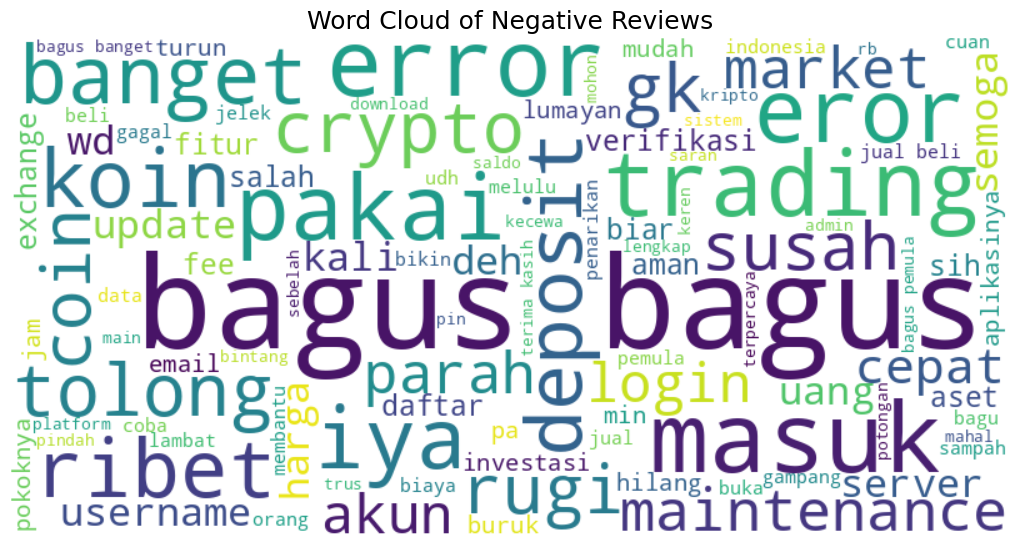

In [27]:
create_wordcloud(negative_tweets['processed_text'], 'Word Cloud of Negative Reviews')

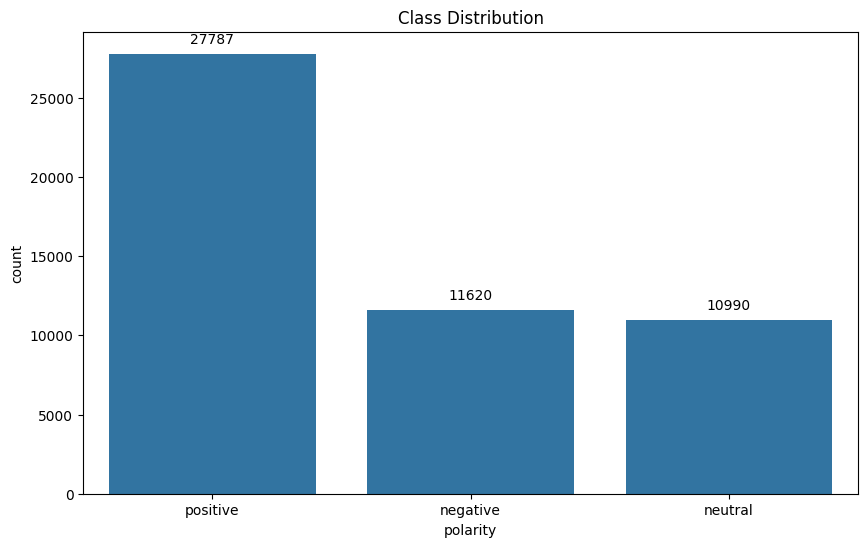

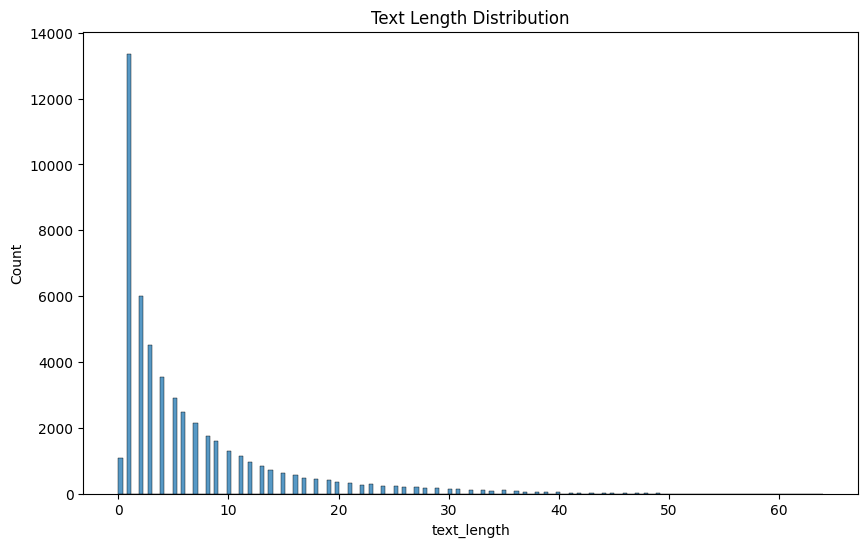

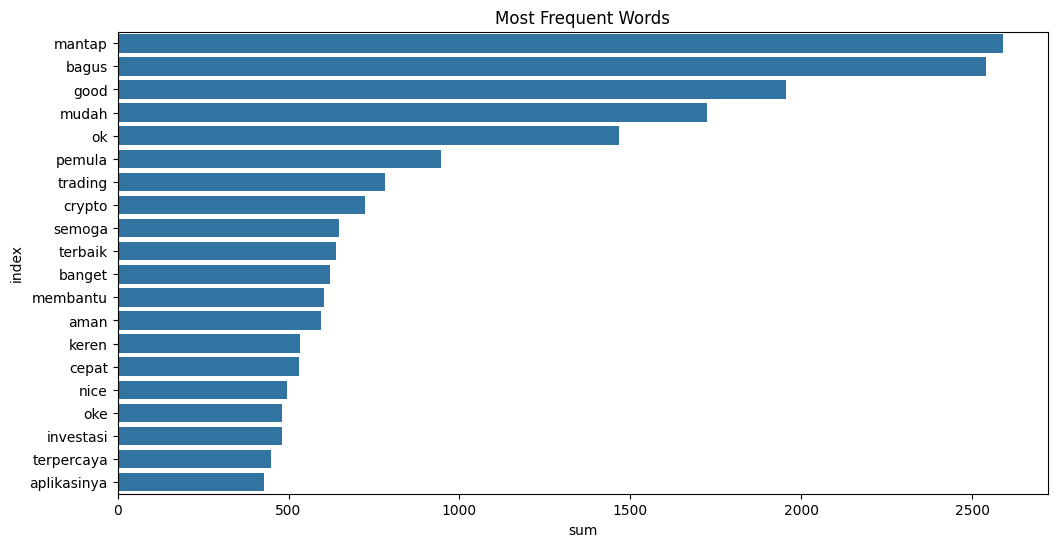

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Set the figure size
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=reviews_df)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0,10),
        textcoords='offset points'
    )

plt.show()

# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
reviews_df['text_length'] = reviews_df['processed_text'].apply(lambda x: len(x.split()))
sns.histplot(reviews_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews_df['processed_text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='sum')
tfidf_df = tfidf_df.sort_values('sum', ascending=False).head(20)
sns.barplot(x='sum', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [29]:
# Feature extraction using TF-IDF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

binary_df = reviews_df[reviews_df['polarity'] != 'neutral'].copy()
binary_df['polarity'] = binary_df['polarity'].map({'positive': 1, 'negative': 0})

# Set parameters
max_features = 5000 # Maximum number of words to keep
maxlen = 100 # Maximum length of reviews

# Create tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(binary_df['filtered_tokens'])

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(binary_df['filtered_tokens'])
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

# Get sentiment labels
y = binary_df['polarity'].values

## Step 4: Build Deep Learning Model

In [30]:
# Import deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


# Build LSTM model
embedding_dim = 128 # Dimension of word embeddings

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 213s 258ms/step - accuracy: 0.8465 - loss: 0.3464 - val_accuracy: 0.9572 - val_loss: 0.1140
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 261s 257ms/step - accuracy: 0.9738 - loss: 0.0768 - val_accuracy: 0.9602 - val_loss: 0.1078
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 262s 258ms/step - accuracy: 0.9861 - loss: 0.0454 - val_accuracy: 0.9575 - val_loss: 0.1122
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 261s 256ms/step - accuracy: 0.9902 - loss: 0.0313 - val_accuracy: 0.9611 - val_loss: 0.1213
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 263s 257ms/step - accuracy: 0.9928 - loss: 0.0252 - val_accuracy: 0.9616 - val_loss: 0.1340
247/247 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9601 - loss: 0.1129
Test Accuracy: 0.9616


## Step 5: Visualize Training Results

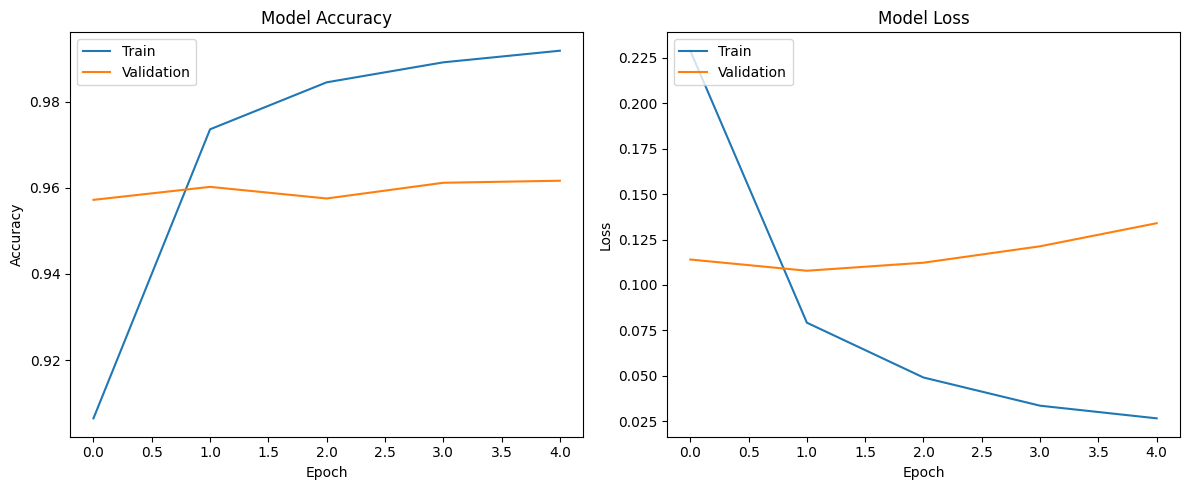

In [32]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Step 6: Analyze Model Performance

247/247 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step
              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      2320
    Positive       0.97      0.98      0.97      5562

    accuracy                           0.96      7882
   macro avg       0.96      0.95      0.95      7882
weighted avg       0.96      0.96      0.96      7882



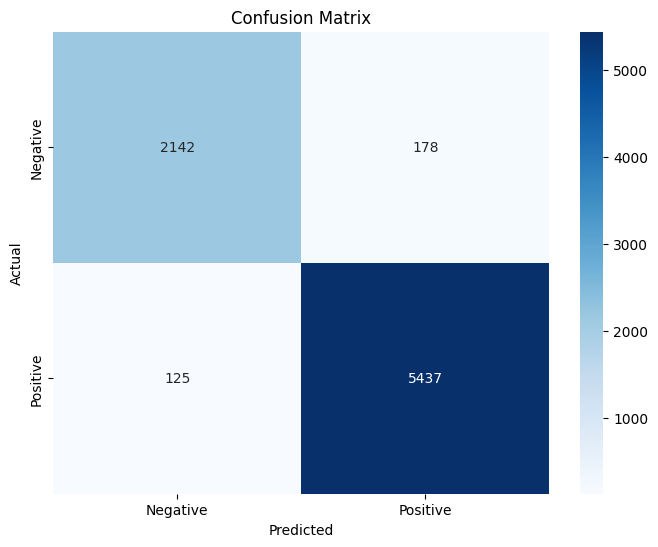

In [33]:
# Import evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Step 7: Make Predictions on New Reviews

In [34]:
# Function to predict sentiment of new reviews
def predict_sentiment(review_text):
    # Preprocess the review
    cleaned = clean_text(review_text)
    casefolded = casefold_text(cleaned)
    slangfix = fix_slangwords(casefolded)
    tokens = tokenize_text(slangfix)
    filtered = filter_stopwords(tokens)
    processed = tokens_to_sentence(filtered)
    stemmed = stem_text(processed)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([stemmed])
    padded = pad_sequences(sequence, maxlen=maxlen)

    # Predict sentiment
    prediction = model.predict(padded)[0][0]
    sentiment = 'Positive' if prediction > 0.5 else ('Neutral' if prediction == 0 else 'Negative')
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'processed_text': stemmed
    }


# Test with sample reviews
sample_reviews = [
    "Aplikasi bagus, mudah digunakan dan transaksi cepat",
    'Sering error dan customer service lambat merespon',
    'Deposit dan withdraw lancar, recommended untuk pemula'
]

for review in sample_reviews:
    result = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Sentiment: {result['sentiment']} (Confidence: {result['confidence']:.2f})")
    print(f"Processed: {result['processed_text']}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Review: Aplikasi bagus, mudah digunakan dan transaksi cepat
Sentiment: Positive (Confidence: 1.00)
Processed: bagus mudah transaksi cepat
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Review: Sering error dan customer service lambat merespon
Sentiment: Negative (Confidence: 0.87)
Processed: error customer service lambat merespon
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Review: Deposit dan withdraw lancar, recommended untuk pemula
Sentiment: Positive (Confidence: 0.99)
Processed: deposit withdraw lancar recommended mula
--------------------------------------------------


## Step 8: Save the model

In [35]:
# Save the model and tokenizer for feature use
model.save('indodax_sentiment_model.h5')

import pickle
with open('indodax_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


print("Model, LabelEncoder, and tokenizer saved successfully.")

Model, LabelEncoder, and tokenizer saved successfully.


## Conclusion

In this project, we've built a deep learning model to analyze sentiment in Indonesian reviews of the Indodax cryptocurrency exchange app. The model can classify reviews as positive or negative, providing valuable insights into user satisfaction and areas for improvement.

The LSTM-based architecture is particularly well-suited for this task as it can capture the sequential nature of text and understand context better than traditional machine learning approaches. By analyzing the common words in positive and negative reviews, the app developers can identify specific features or issues that users appreciate or complain about.

This sentiment analysis can help Indodax:
1. Identify and address common user complaints
2. Understand what features users value most
3. Track sentiment changes over time after app updates
4. Compare their app's reception to competitors

For further improvements, you could:
- Collect more reviews for better training
- Experiment with different architectures (e.g., transformers)
- Implement aspect-based sentiment analysis to identify specific features mentioned in reviews
- Create a dashboard to monitor sentiment trends over time